# Create Network for Main Path Creation in Pajek


In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from src.network.creation.PajekNetworkCreator import PajekNetworkCreator
from src.network.creation.PajekNetworkCreatorUtils import (
    PajekNetworkCreatorUtils as utils,
)

# show all columns
pd.set_option("display.max_columns", None)

In [45]:
# read in G
p = "../data/05-graphs/citation-graph/directed_citation_graph.graphml"
G_og = nx.read_graphml(p)

# clean graph

- clean attributes
- remove loops by creating familiy nodes (see Liu 2019)
- remove isolates
  extract largest weakly connected component (WCC)


In [47]:
creator = PajekNetworkCreator(
    G_og,
)
Gpjk, log = creator.prepare_pajek()

print(f"Original number of nodes: {G_og.number_of_nodes()}")
print(f"Original number of edges: {G_og.number_of_edges()}")
print(f"New number of nodes: {Gpjk.number_of_nodes()}")
print(f"New number of edges: {Gpjk.number_of_edges()}")

print(f" Removed bc loops: {log['loops_removed']['count']}")
print(f" Removed bc isolates: {log['isolates_removed']['count']}")
print(f" Removed bc largest wcc: {log['largest_wcc_removed']['count']}")

Original number of nodes: 40643
Original number of edges: 360645
New number of nodes: 37587
New number of edges: 358235
 Removed bc loops: 73
 Removed bc isolates: 2778
 Removed bc largest wcc: 153


# Resolve family issues

**PROBLEM**: Some large families are built due to updated cochane reviews. They are updated and this creates citation loops and bidirectional citations. This is a problem for the main path analysis.

We solve it the following way:

1. we keep families of up to three members.
2. we keep familiess of greater sizes if they are all published in the same journal issue.
3. Families due to updated cochrane reviews are dissolved by removing edges.
   1. Bidirectional edges are removed, the edge that is going against time is removed.
   2. Other edges that are counterchronological are removed until the cycle is dissolved.


In [48]:
p = "/Users/jlq293/Projects/Study-1-Bibliometrics/data/04-embeddings/df_with_specter2_embeddings.pkl"
df = pd.read_pickle(p)

In [49]:
# Initialize loop_log
loop_log = {
    "nr_of_loops": 0,
    "special_issue_loops": 0,
    "sizes_counts": Counter(),
    "no_special_issue_and_more_than_3": 0,
    "cochrane_update_loops": 0,
}

df_family_dict = {}

for node in Gpjk.nodes(data=True):
    label = node[0]
    if label.startswith("family"):
        # Create loop dataframe
        df_loop = utils.loop_to_df(node, df).reset_index(drop=True)

        # Update loop_log
        loop_log["nr_of_loops"] += 1
        loop_log["sizes_counts"].update([df_loop.shape[0]])

        # Check for special issue
        journals = df_loop["journal"].unique()
        cochrane = any("cochrane" in journal.lower() for journal in journals if journal)
        loop_log["cochrane_update_loops"] += cochrane
        if len(journals) == 1:
            special_issue = True
            loop_log["special_issue_loops"] += 1
        else:
            special_issue = False

        # Check for dissolving condition
        to_dissolve = not len(journals) == 1 and df_loop.shape[0] > 3

        # Store family information
        df_family_dict[label] = {
            "df": df_loop,
            "special_issue": special_issue,
            "to_dissolve": to_dissolve,
        }

# Calculate no_special_issue_and_more_than_3
loop_log["no_special_issue_and_more_than_3"] = sum(
    family_info["to_dissolve"] for family_info in df_family_dict.values()
)

loop_log

{'nr_of_loops': 73,
 'special_issue_loops': 43,
 'sizes_counts': Counter({2: 61, 4: 5, 3: 3, 10: 1, 13: 1, 16: 1, 8: 1}),
 'no_special_issue_and_more_than_3': 7,
 'cochrane_update_loops': 10}

# Take closer look at loops to dissolve


# Families to fix


In [50]:
df_family_dict.keys()

for k, v in df_family_dict.items():
    if v["to_dissolve"]:
        print(k)
        print("-" * 40)

family_Anghelescu_2006_Gastpar_2006_Linde_2009_Szegedi_2005_2
----------------------------------------
family_Brown_2009_2_Pearlstein_2005_Yonkers_2005_Yonkers_2006
----------------------------------------
family_Brown_2014_Carrao_2007_Howes_2020_Hughes_2005_Hughes_2007_2_Hughes_2014_2_Minami_2014_Minami_2015_Spring_2007_VanDerMeer_2013
----------------------------------------
family_Carpenter_2011_Cipriani_2009_3_Cipriani_2009_4_Gibiino_2012_Hetrick_2007_Imperadore_2007_Klinger_2011_Kronenberg_2008_Magni_2013_Omori_2010_Purgato_2014_Schneeweiss_2010_2_Sie_2012
----------------------------------------
family_Asakura_2016_Bandelow_2008_2_Bandelow_2012_Bandelow_2015_Blanco_2013_Book_2008_Davis_2014_Dempsey_2009_Faria_2012_Faria_2014_Nordahl_2016_Phan_2013_Ravindran_2010_Thomas_2008_3_Williams_2017_Yoshinaga_2013
----------------------------------------
family_Ayerbe_2014_He_2018_2_Kraglund_2018_Legg_2019_Mortensen_2015_Mortensen_2015_2_Pan_2018_2_Siepmann_2015_2
-------------------------

In [51]:
removed_edges = []

# family_Anghelescu_2006_Gastpar_2006_Linde_2009_Szegedi_2005_2


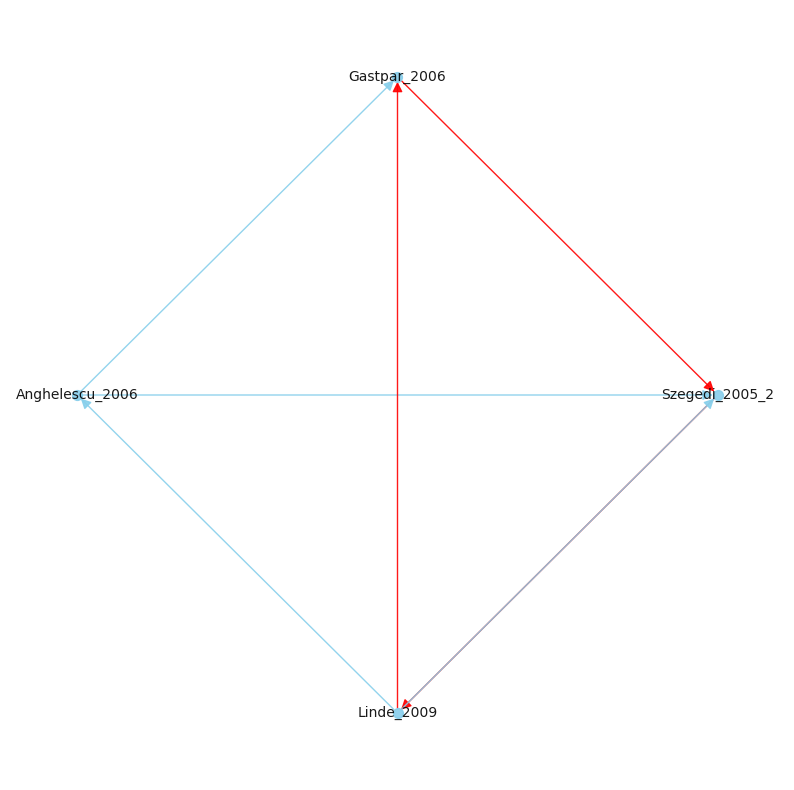

Reverse timed citation edges:
('Szegedi_2005_2', 'Linde_2009')
Cochrane Reviews:  Linde_2009


In [52]:
fam = "family_Anghelescu_2006_Gastpar_2006_Linde_2009_Szegedi_2005_2"
df_fam = df_family_dict[fam]["df"]

G, reversed_edges = utils.create_graph_from_family(df_fam)

True
False


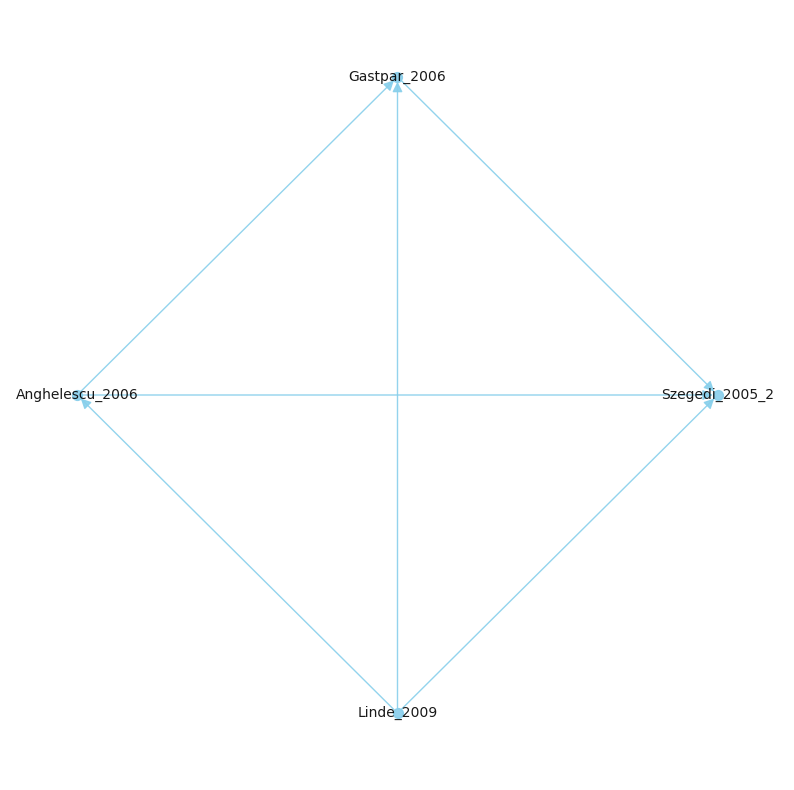

In [53]:
print(utils.G_is_a_cycle(G))

edge_to_remove = ("Szegedi_2005_2", "Linde_2009")

G.remove_edge(edge_to_remove[0], edge_to_remove[1])
removed_edges.append(edge_to_remove)

G_og.remove_edge("Szegedi_2005_2", "Linde_2009")

print(utils.G_is_a_cycle(G))

utils.draw_graph(G)

# family_Brown_2009_2_Pearlstein_2005_Yonkers_2005_Yonkers_2006


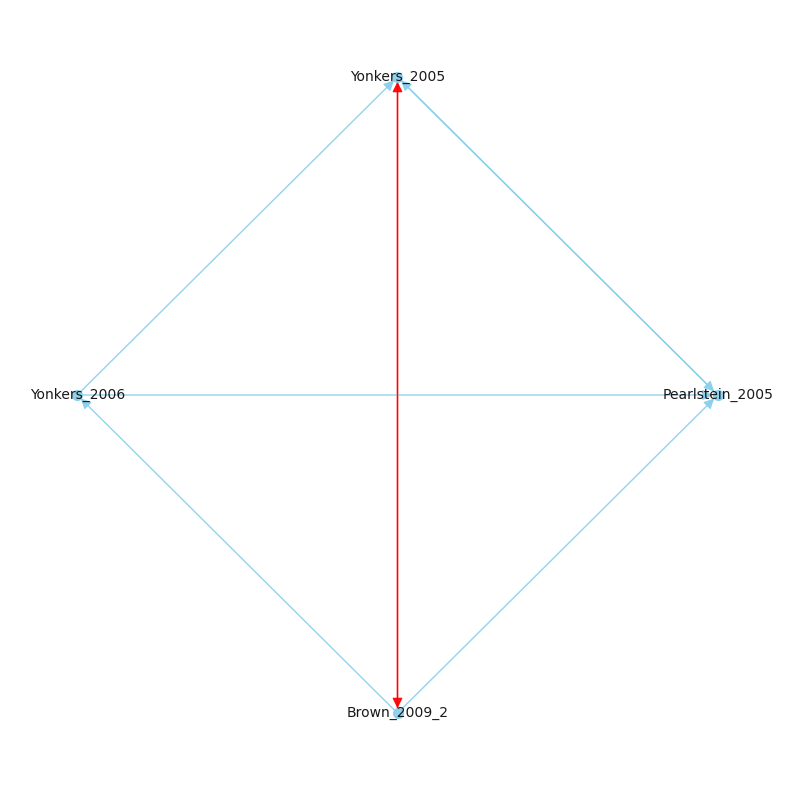

Reverse timed citation edges:
('Yonkers_2005', 'Brown_2009_2')
Cochrane Reviews:  Brown_2009_2


In [54]:
fam = "family_Brown_2009_2_Pearlstein_2005_Yonkers_2005_Yonkers_2006"
df_fam = df_family_dict[fam]["df"]

G, reversed_edges = utils.create_graph_from_family(df_fam)

In [55]:
# remove the edge 'Linde_2009' -> 'Szegedi_2005_2' is a false time loop
print(utils.G_is_a_cycle(G))

edge_to_remove = ("Yonkers_2005", "Brown_2009_2")
G.remove_edge(edge_to_remove[0], edge_to_remove[1])
removed_edges.append(edge_to_remove)
G_og.remove_edge(edge_to_remove[0], edge_to_remove[1])

edge_to_remove = ("Yonkers_2005", "Pearlstein_2005")
G.remove_edge(edge_to_remove[0], edge_to_remove[1])
removed_edges.append(edge_to_remove)  #

print(utils.G_is_a_cycle(G))

True
False


# family_Brown_2014_Carrao_2007_Howes_2020_Hughes_2005_Hughes_2007_2_Hughes_2014_2_Minami_2014_Minami_2015_Spring_2007_VanDerMeer_2013


In [56]:
df_family_dict[fam]["df"]

,unique_auth_year,journal,eid,title,citedby_count,reference_eids,nr_references,filtered_reference_eids,api_url,doi
0,Pearlstein_2005,Journal of Affective Disorders,2-s2.0-15244352996,Pretreatment pattern of symptom expression in ...,103,"[2-s2.0-0036842555, 2-s2.0-0033819681, 2-s2.0-...",22,"[2-s2.0-15244347801, 2-s2.0-0036842555, 2-s2.0...",https://api.elsevier.com/content/abstract/scop...,10.1016/j.jad.2004.10.004
1,Yonkers_2005,Journal of Affective Disorders,2-s2.0-15244347801,Luteal phase treatment of premenstrual dysphor...,24,"[2-s2.0-0032527557, 2-s2.0-9844253329, 2-s2.0-...",9,"[2-s2.0-0032527557, 2-s2.0-9844253329, 2-s2.0-...",https://api.elsevier.com/content/abstract/scop...,10.1016/j.jad.2004.10.006
2,Yonkers_2006,Journal of Clinical Psychopharmacology,2-s2.0-33646684711,Symptom-onset treatment for women with premens...,36,"[2-s2.0-72949151592, 2-s2.0-0031952365, 2-s2.0...",29,"[2-s2.0-15244347801, 2-s2.0-0033238137, 2-s2.0...",https://api.elsevier.com/content/abstract/scop...,10.1097/01.jcp.0000203197.03829.ae
3,Brown_2009_2,Cochrane Database of Systematic Reviews,2-s2.0-69849083027,Selective serotonin reuptake inhibitors for pr...,80,"[2-s2.0-28944442974, 2-s2.0-0027256320, 2-s2.0...",108,"[2-s2.0-0028817732, 2-s2.0-1642527869, 2-s2.0-...",https://api.elsevier.com/content/abstract/scop...,10.1002/14651858.CD001396.pub2


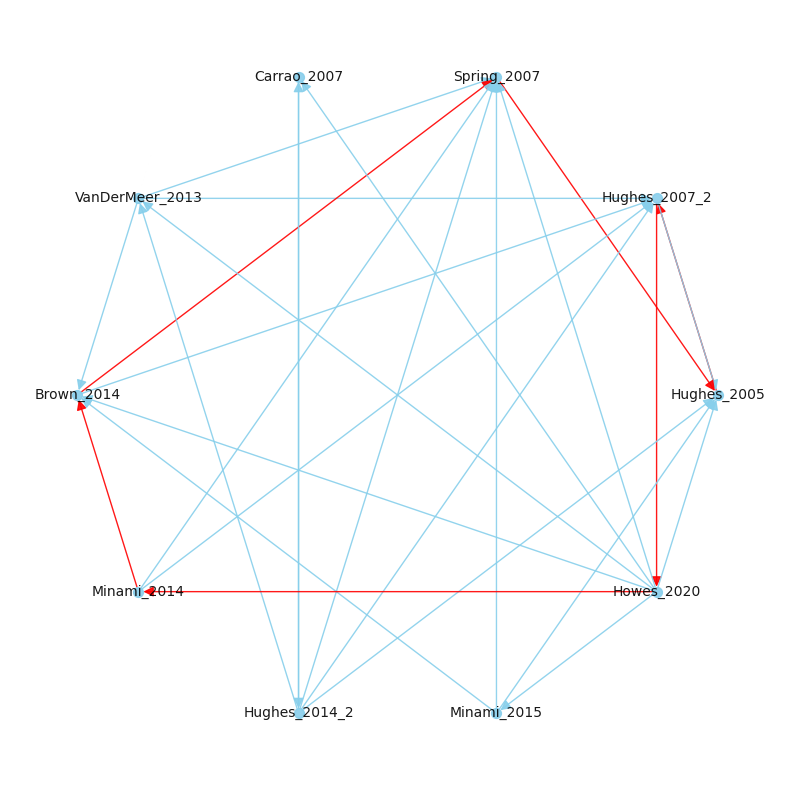

Reverse timed citation edges:
('Hughes_2005', 'Hughes_2007_2')
('Hughes_2007_2', 'Howes_2020')
('Carrao_2007', 'Hughes_2014_2')
('VanDerMeer_2013', 'Brown_2014')
Cochrane Reviews:  Hughes_2007_2; VanDerMeer_2013; Hughes_2014_2; Howes_2020


In [57]:
fam = "family_Brown_2014_Carrao_2007_Howes_2020_Hughes_2005_Hughes_2007_2_Hughes_2014_2_Minami_2014_Minami_2015_Spring_2007_VanDerMeer_2013"
df_fam = df_family_dict[fam]["df"]

G, reversed_edges = utils.create_graph_from_family(df_fam)

Removed bidirectional edge:  ('Hughes_2005', 'Hughes_2007_2')
Removed bidirectional edge:  ('Carrao_2007', 'Hughes_2014_2')
Bidirectional edges removed: 2
Cycle found in the graph


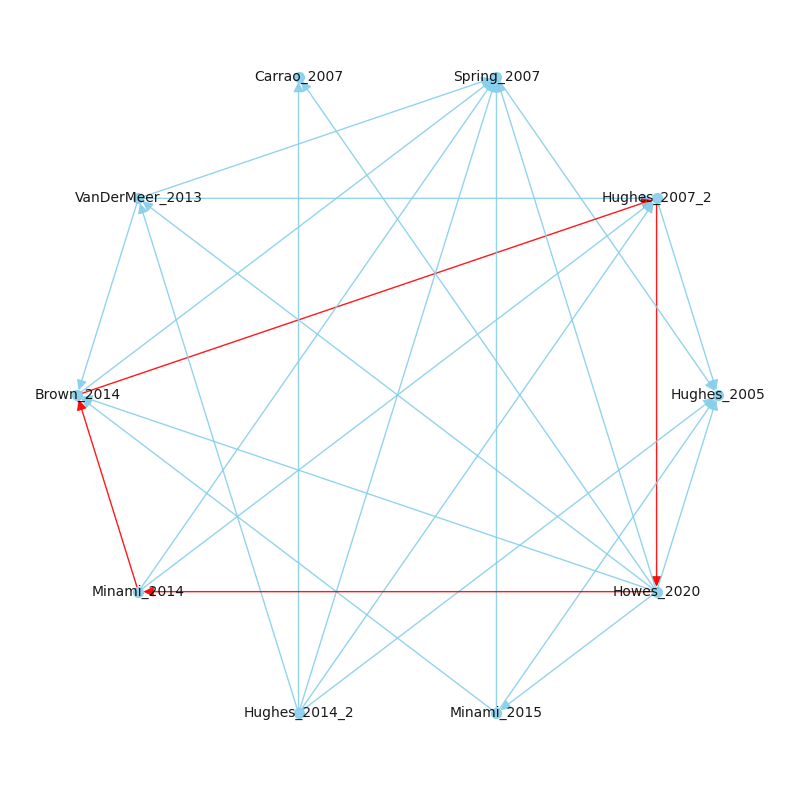

In [58]:
G, bidirectional_edges_removed = utils.remove_reverse_time_bidirectional_edge(G)
print("Bidirectional edges removed:", len(bidirectional_edges_removed))

G_og.remove_edges_from(bidirectional_edges_removed)
removed_edges.extend(bidirectional_edges_removed)

if utils.G_is_a_cycle(G):
    print("Cycle found in the graph")
    utils.draw_graph(G)

Removed edge: ('Hughes_2007_2', 'Howes_2020')
No cycle found in the graph


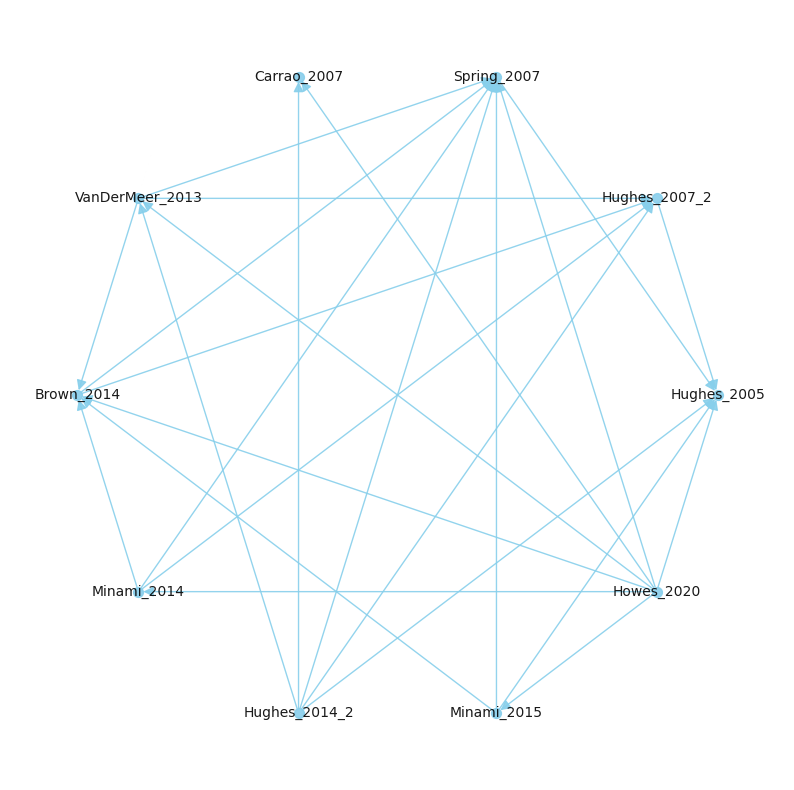

In [59]:
reversed_edges = [
    edge for edge in reversed_edges if edge not in bidirectional_edges_removed
]

for edge in reversed_edges:
    if utils.G_is_a_cycle(G):
        G.remove_edge(edge[0], edge[1])
        removed_edges.append(edge)
        G_og.remove_edge(edge[0], edge[1])
        print("Removed edge:", edge)

if not utils.G_is_a_cycle(G):
    print("No cycle found in the graph")
utils.draw_graph(G)

In [60]:
print(df_fam[df_fam["unique_auth_year"] == "Spring_2007"]["api_url"].values[0])
print(df_fam[df_fam["unique_auth_year"] == "Spring_2007"]["doi"].values[0])

print("Looking at the paper, the citations in Scopus seem to be false")

https://api.elsevier.com/content/abstract/scopus_id/33846984990
10.1037/0022-006X.75.1.85
Looking at the paper, the citations in Scopus seem to be false


In [61]:
print(df_fam[df_fam["unique_auth_year"] == "Minami_2015"]["api_url"].values[0])
print(df_fam[df_fam["unique_auth_year"] == "Minami_2015"]["doi"].values[0])

print(
    "Looking at the paper, the citations in Scopus seem to be false (minami does not cite howes 2020)"
)

https://api.elsevier.com/content/abstract/scopus_id/84924202566
10.1097/ADT.0000000000000042
Looking at the paper, the citations in Scopus seem to be false (minami does not cite howes 2020)


# family_Carpenter_2011_Cipriani_2009_3_Cipriani_2009_4_Gibiino_2012_Hetrick_2007_Imperadore_2007_Klinger_2011_Kronenberg_2008_Magni_2013_Omori_2010_Purgato_2014_Schneeweiss_2010_2_Sie_2012


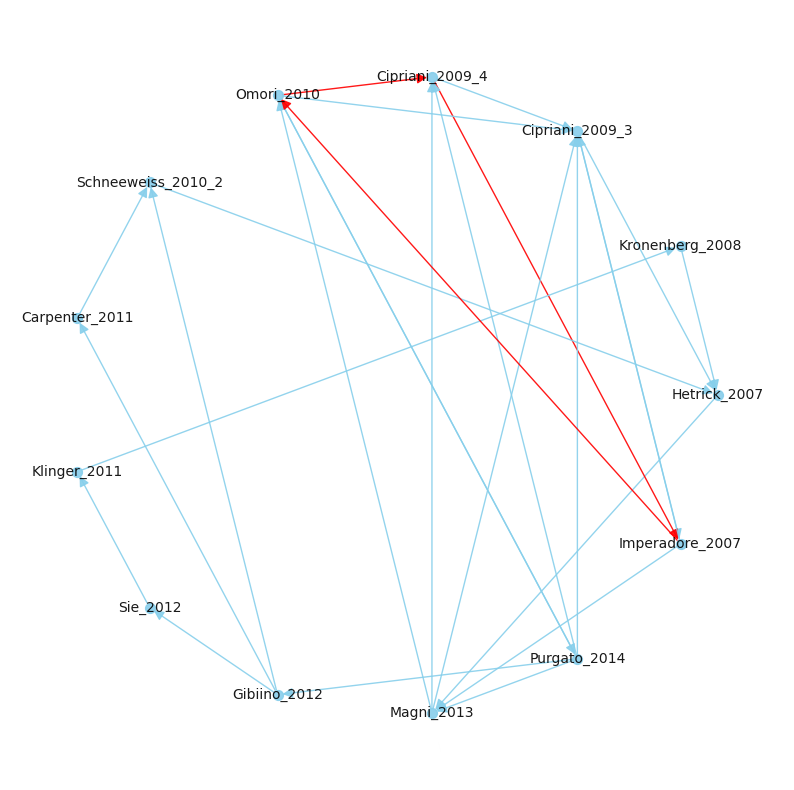

Reverse timed citation edges:
('Hetrick_2007', 'Magni_2013')
('Omori_2010', 'Purgato_2014')
('Imperadore_2007', 'Omori_2010')
('Imperadore_2007', 'Magni_2013')
('Imperadore_2007', 'Cipriani_2009_3')
Cochrane Reviews:  Hetrick_2007; Cipriani_2009_3; Cipriani_2009_4; Omori_2010; Magni_2013; Purgato_2014; Imperadore_2007


In [62]:
fam = "family_Carpenter_2011_Cipriani_2009_3_Cipriani_2009_4_Gibiino_2012_Hetrick_2007_Imperadore_2007_Klinger_2011_Kronenberg_2008_Magni_2013_Omori_2010_Purgato_2014_Schneeweiss_2010_2_Sie_2012"
df_fam = df_family_dict[fam]["df"]

G, reversed_edges = utils.create_graph_from_family(df_fam)

Removed bidirectional edge:  ('Omori_2010', 'Purgato_2014')
Removed bidirectional edge:  ('Imperadore_2007', 'Cipriani_2009_3')
Bidirectional edges removed: 2
Cycle found in the graph


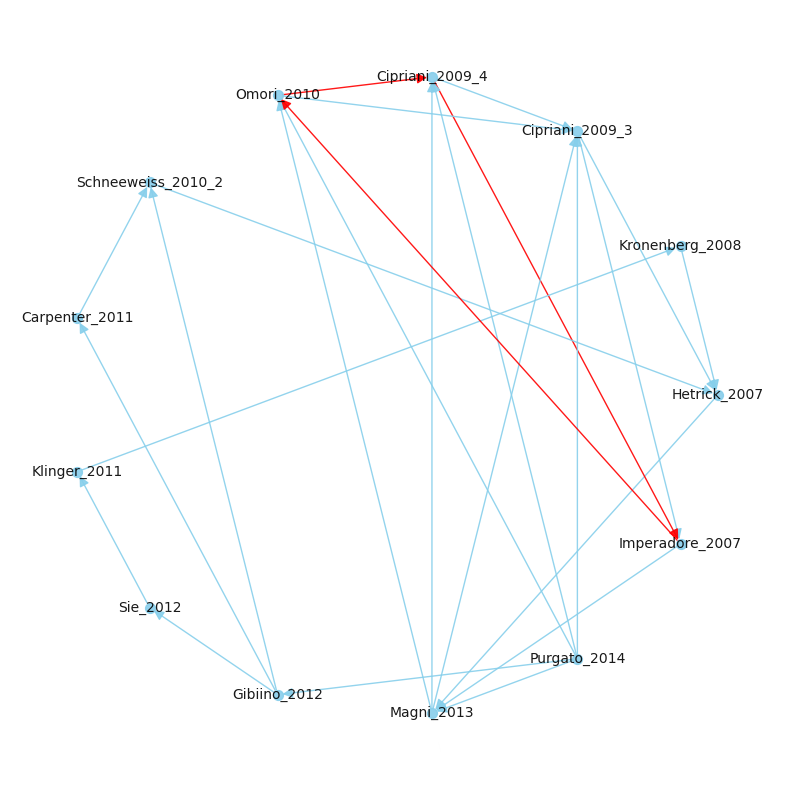

In [63]:
G, bidirectional_edges_removed = utils.remove_reverse_time_bidirectional_edge(G)
print("Bidirectional edges removed:", len(bidirectional_edges_removed))

removed_edges.extend(bidirectional_edges_removed)

if utils.G_is_a_cycle(G):
    print("Cycle found in the graph")
    utils.draw_graph(G)

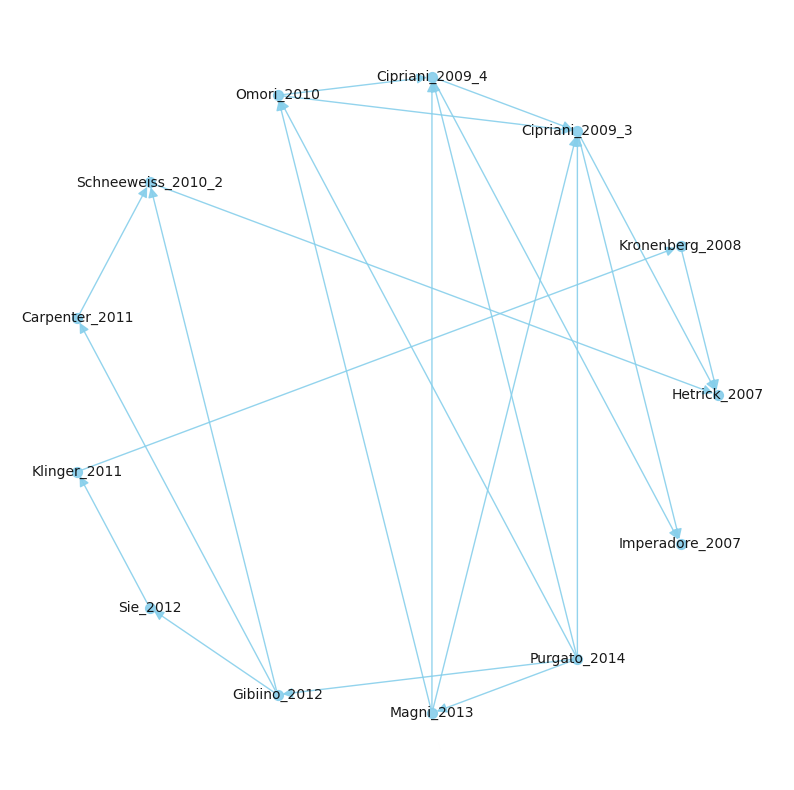

In [64]:
reversed_edges = [
    edge for edge in reversed_edges if edge not in bidirectional_edges_removed
]

for edge in reversed_edges:
    if utils.G_is_a_cycle(G):
        G.remove_edge(edge[0], edge[1])
        removed_edges.append(edge)
        G_og.remove_edge(edge[0], edge[1])

if utils.G_is_a_cycle(G):
    print("No cycle found in the graph")
utils.draw_graph(G)

# family_Asakura_2016_Bandelow_2008_2_Bandelow_2012_Bandelow_2015_Blanco_2013_Book_2008_Davis_2014_Dempsey_2009_Faria_2012_Faria_2014_Nordahl_2016_Phan_2013_Ravindran_2010_Thomas_2008_3_Williams_2017_Yoshinaga_2013


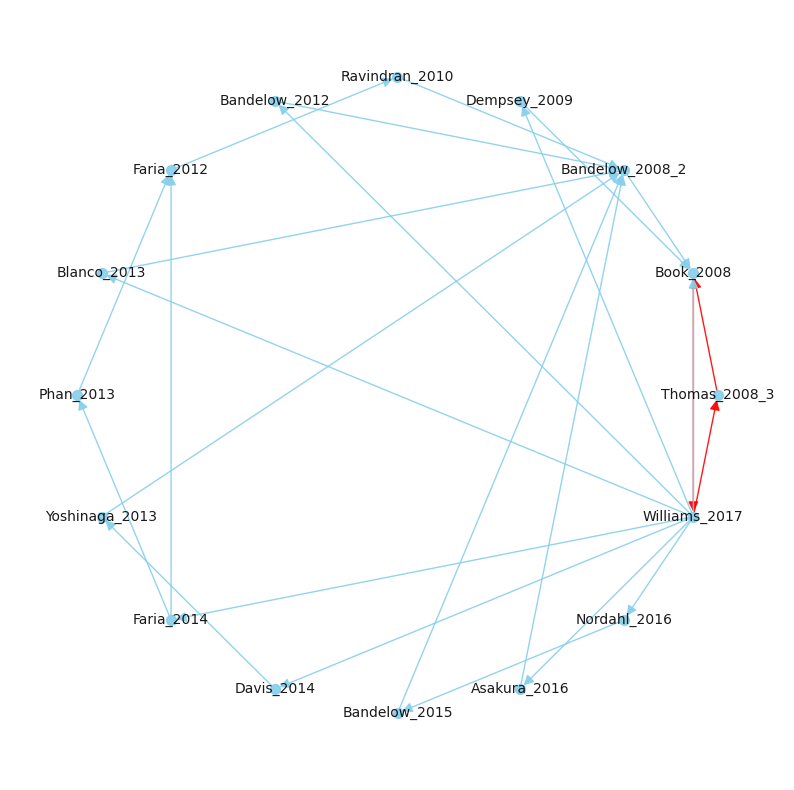

Reverse timed citation edges:
('Book_2008', 'Williams_2017')
Cochrane Reviews:  Williams_2017


In [65]:
fam = "family_Asakura_2016_Bandelow_2008_2_Bandelow_2012_Bandelow_2015_Blanco_2013_Book_2008_Davis_2014_Dempsey_2009_Faria_2012_Faria_2014_Nordahl_2016_Phan_2013_Ravindran_2010_Thomas_2008_3_Williams_2017_Yoshinaga_2013"
df_fam = df_family_dict[fam]["df"]

G, reversed_edges = utils.create_graph_from_family(df_fam)

In [66]:
# remove bidirectional edges
G, bidirectional_edges_removed = utils.remove_reverse_time_bidirectional_edge(G)

print("Bidirectional edges removed:", len(bidirectional_edges_removed))

G_og.remove_edges_from(bidirectional_edges_removed)

removed_edges.extend(bidirectional_edges_removed)

if utils.G_is_a_cycle(G):
    print("Cycle found in the graph")
    utils.draw_graph(G)

Removed bidirectional edge:  ('Book_2008', 'Williams_2017')
Bidirectional edges removed: 1


No cycle found in the graph


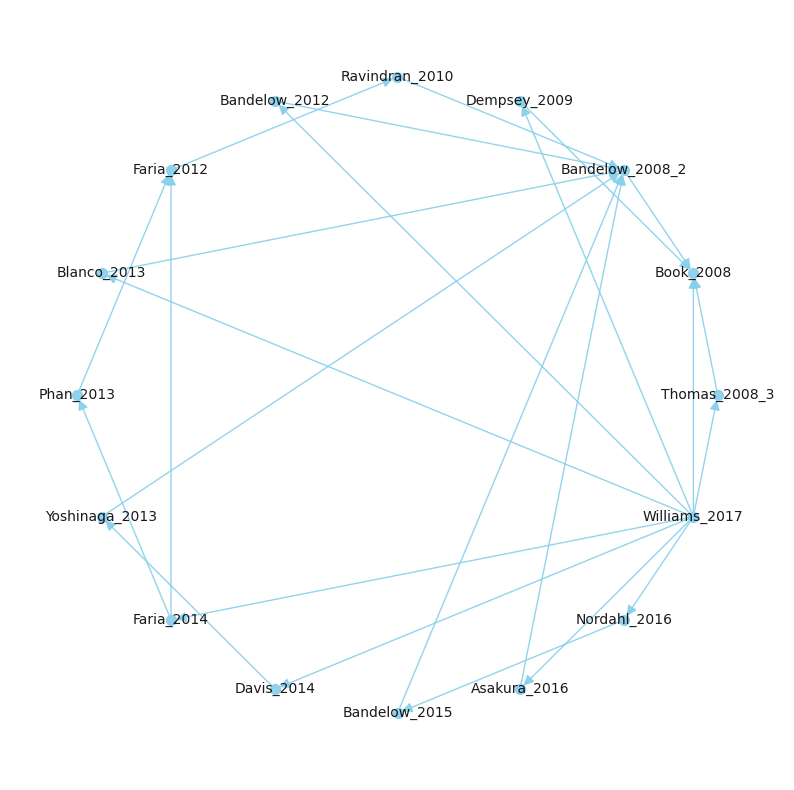

In [67]:
reversed_edges = [
    edge for edge in reversed_edges if edge not in bidirectional_edges_removed
]

for edge in reversed_edges:
    if utils.G_is_a_cycle(G):
        G.remove_edge(edge[0], edge[1])
        removed_edges.append(edge)
        G_og.remove_edge(edge[0], edge[1])
        print("Removed edge:", edge)
    else:
        break

if not utils.G_is_a_cycle(G):
    print("No cycle found in the graph")
    utils.draw_graph(G)

In [68]:
print(df_fam[df_fam["unique_auth_year"] == "Williams_2017"]["api_url"].values[0])
print(df_fam[df_fam["unique_auth_year"] == "Williams_2017"]["doi"].values[0])

https://api.elsevier.com/content/abstract/scopus_id/85032856752
10.1002/14651858.CD001206.pub3


# family_Ayerbe_2014_He_2018_2_Kraglund_2018_Legg_2019_Mortensen_2015_Mortensen_2015_2_Pan_2018_2_Siepmann_2015_2


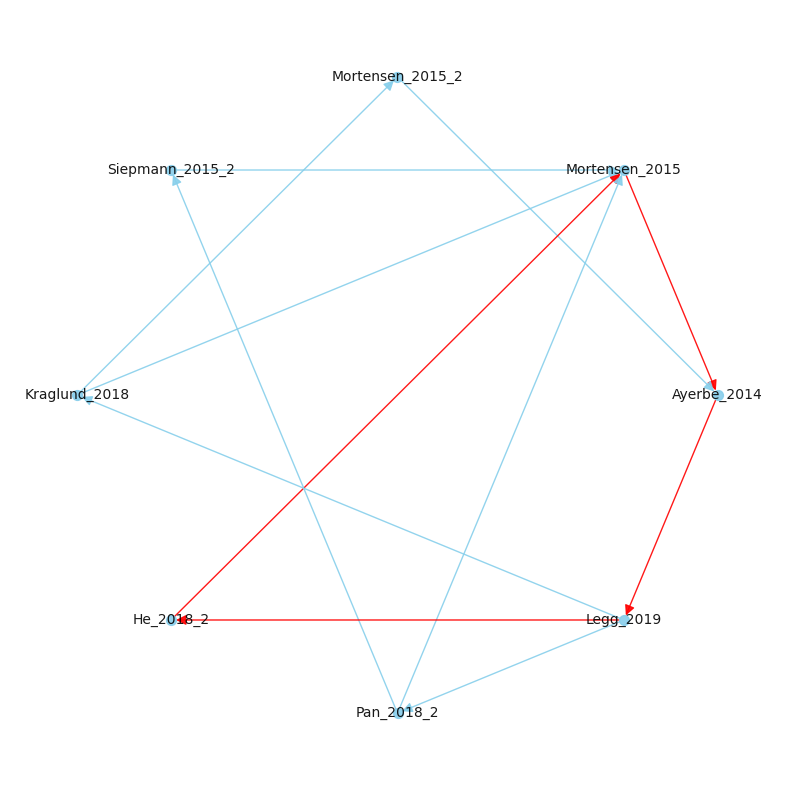

Reverse timed citation edges:
('Ayerbe_2014', 'Legg_2019')
Cochrane Reviews:  Legg_2019


In [69]:
fam = "family_Ayerbe_2014_He_2018_2_Kraglund_2018_Legg_2019_Mortensen_2015_Mortensen_2015_2_Pan_2018_2_Siepmann_2015_2"
df_fam = df_family_dict[fam]["df"]

G, reversed_edges = utils.create_graph_from_family(df_fam)

Bidirectional edges removed: 0
Cycle found in the graph


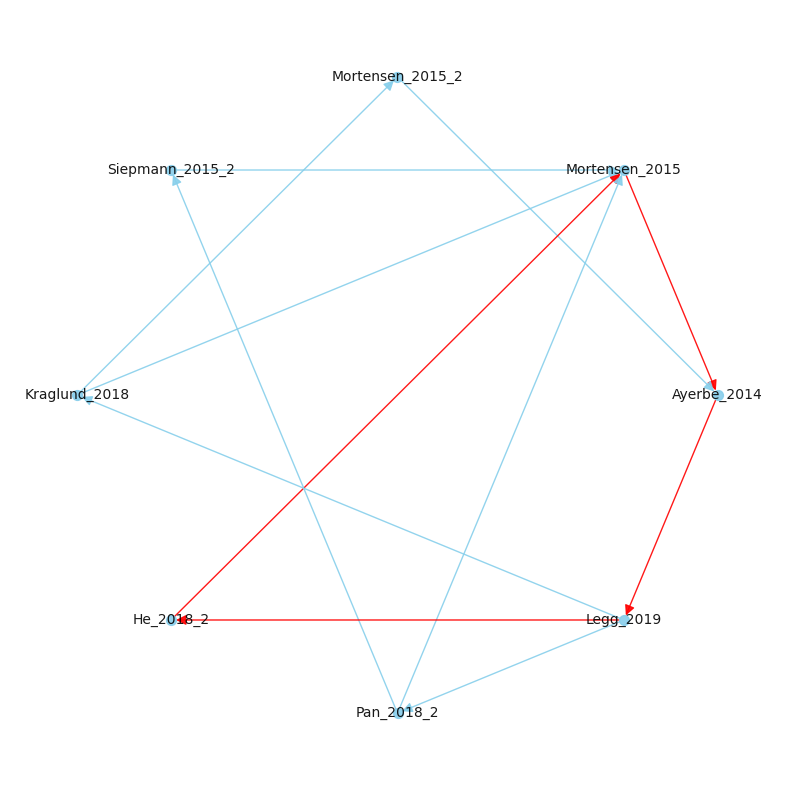

In [70]:
# remove bidirectional edges
G, bidirectional_edges_removed = utils.remove_reverse_time_bidirectional_edge(G)
print("Bidirectional edges removed:", len(bidirectional_edges_removed))
removed_edges.extend(bidirectional_edges_removed)

if utils.G_is_a_cycle(G):
    print("Cycle found in the graph")
    utils.draw_graph(G)

Removed edge Ayerbe_2014 -> Legg_2019


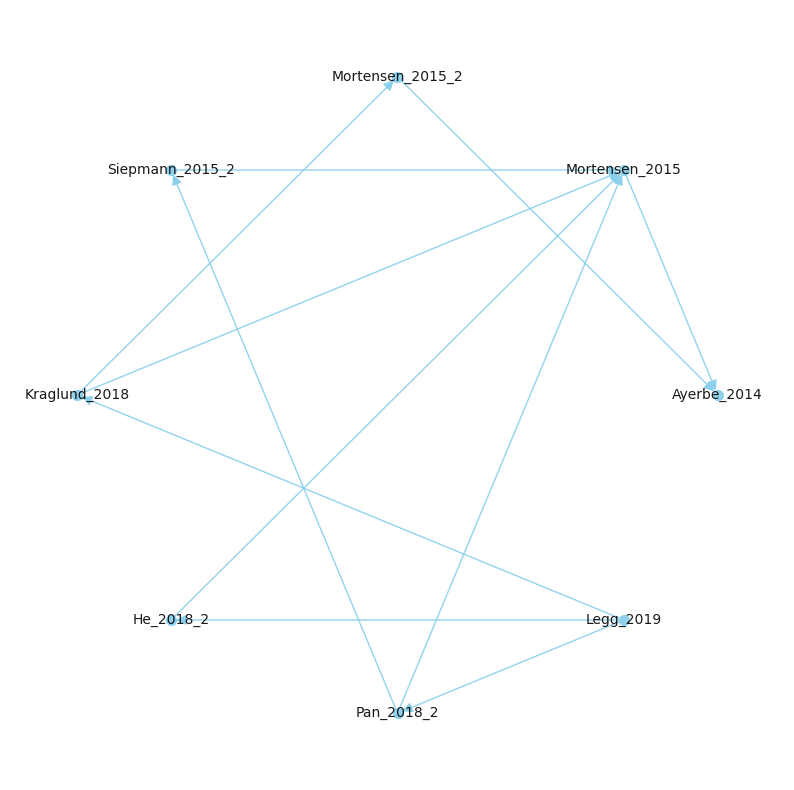

In [71]:
reversed_edges = [
    edge for edge in reversed_edges if edge not in bidirectional_edges_removed
]

for edge in reversed_edges:
    if utils.G_is_a_cycle(G):
        G.remove_edge(edge[0], edge[1])
        removed_edges.append(edge)
        G_og.remove_edge(edge[0], edge[1])
        print(f"Removed edge {edge[0]} -> {edge[1]}")
    else:
        break

if utils.G_is_a_cycle(G):
    print("No cycle found in the graph")
utils.draw_graph(G)

# family_Ayerbe_2015_Legg_2021_MarquezRomero_2020_Yeo_2017


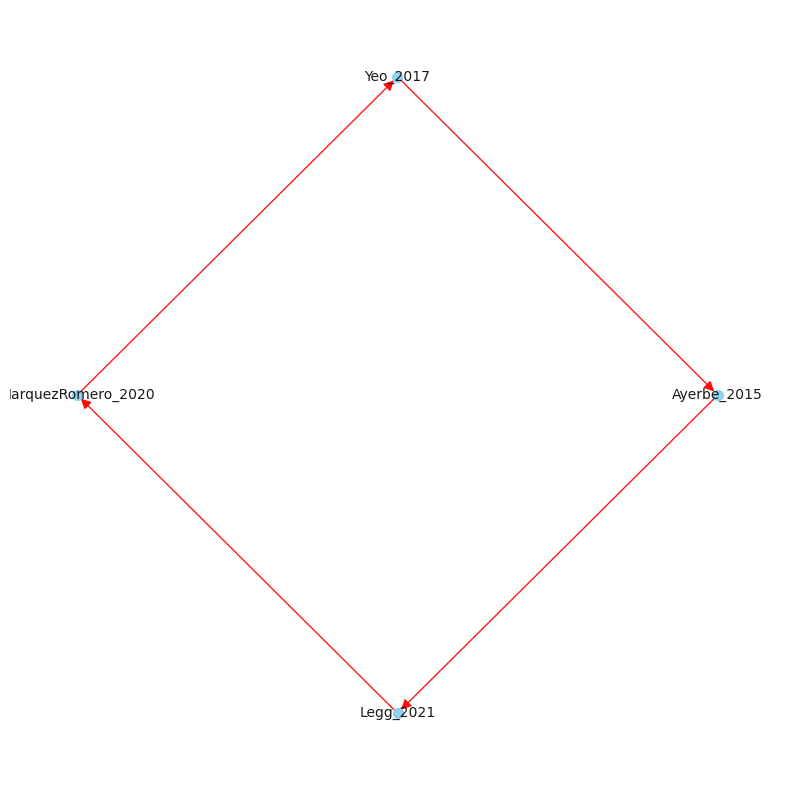

Reverse timed citation edges:
('Ayerbe_2015', 'Legg_2021')
Cochrane Reviews:  Legg_2021


In [72]:
fam = "family_Ayerbe_2015_Legg_2021_MarquezRomero_2020_Yeo_2017"
df_fam = df_family_dict[fam]["df"]

G, reversed_edges = utils.create_graph_from_family(df_fam)

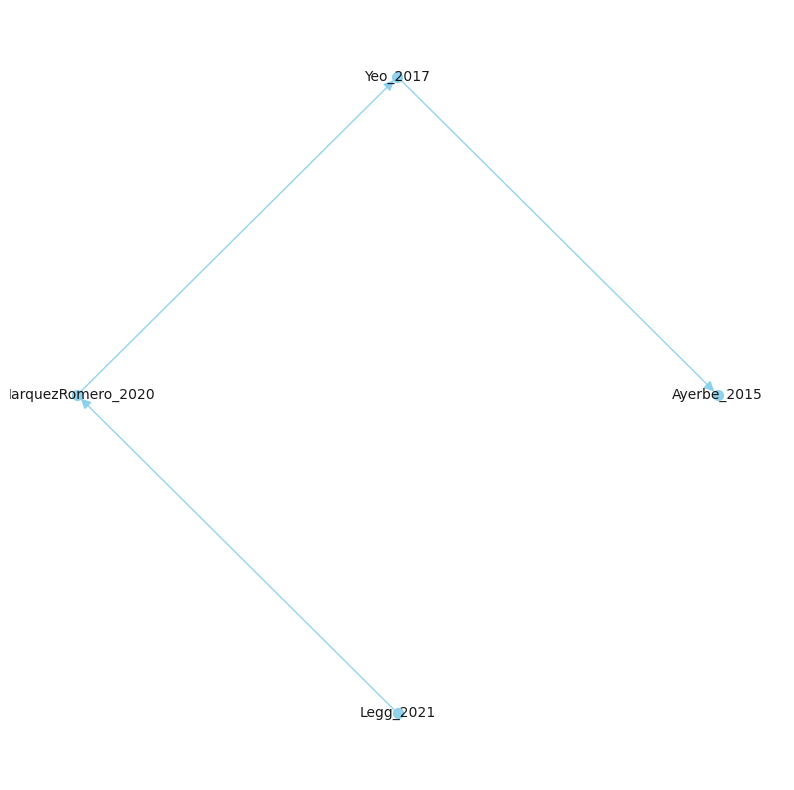

In [73]:
edges_to_remove = ("Ayerbe_2015", "Legg_2021")

G.remove_edge(*edges_to_remove)

G_og.remove_edge(*edges_to_remove)

removed_edges.append(edges_to_remove)

if utils.G_is_a_cycle(G):
    print("Cycle found in the graph")
utils.draw_graph(G)

# Build network anew


In [76]:
log["edges_removed"] = removed_edges

with open("../output/removal_log/directed_network_info_log_pajek.json", "w") as f:
    json.dump(log, f)

create families again


In [77]:
creator = PajekNetworkCreator(G_og)
Gpjk, log = creator.prepare_pajek()

# Initialize loop_log
loop_log = {
    "nr_of_loops": 0,
    "special_issue_loops": 0,
    "sizes_counts": Counter(),
    "no_special_issue_and_more_than_3": 0,
    "cochrane_update_loops": 0,
}

df_family_dict = {}

for node in Gpjk.nodes(data=True):
    label = node[0]
    if label.startswith("family"):
        # Create loop dataframe
        df_loop = utils.loop_to_df(node, df).reset_index(drop=True)

        # Update loop_log
        loop_log["nr_of_loops"] += 1
        loop_log["sizes_counts"].update([df_loop.shape[0]])

        # Check for special issue
        journals = df_loop["journal"].unique()
        cochrane = any("cochrane" in journal.lower() for journal in journals if journal)
        loop_log["cochrane_update_loops"] += cochrane
        if len(journals) == 1:
            special_issue = True
            loop_log["special_issue_loops"] += 1
        else:
            special_issue = False

        # Check for dissolving condition
        to_dissolve = not len(journals) == 1 and df_loop.shape[0] > 3

        # Store family information
        df_family_dict[label] = {
            "df": df_loop,
            "special_issue": special_issue,
            "to_dissolve": to_dissolve,
        }

# Calculate no_special_issue_and_more_than_3
loop_log["no_special_issue_and_more_than_3"] = sum(
    family_info["to_dissolve"] for family_info in df_family_dict.values()
)

loop_log

{'nr_of_loops': 69,
 'special_issue_loops': 46,
 'sizes_counts': Counter({2: 63, 3: 4, 4: 2}),
 'no_special_issue_and_more_than_3': 0,
 'cochrane_update_loops': 5}

In [78]:
df_family_dict.keys()
dissolve = 0
for k, v in df_family_dict.items():
    if v["to_dissolve"]:
        print(k)
        print("-" * 40)
        dissolve += 1

if dissolve == 0:
    print("No family to dissolve")

No family to dissolve


In [79]:
# save to pajek
p = "../data/05-graphs/citation-graph/directed_citation_graph_loopless_pjk.net"
nx.write_pajek(Gpjk, p)

/Users/jlq293/Projects/Study-1-Bibliometrics/.conda/lib/python3.11/site-packages/networkx/readwrite/pajek.py:75: UserWarning: Node attribute unique_auth_year is not processed. Empty attribute.
  warnings.warn(
